In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [66]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [67]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [90]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True #BatchNorm must be in the right state for training vs evaluation
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T // self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out
  
  def parameters(self):
    return[]
# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [9]:
torch.manual_seed(42); # seed rng for reproducibility


In [113]:
n_embd = 24 # the dimenstionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layter of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer (make it less confident)

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of total parameters

for p in parameters:
    p.requires_grad = True

76579


In [114]:
# Lets take a look at how we can implement WaveNet architecture
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  5, 13,  9, 12],
        [ 0,  0,  0,  0,  0,  0,  0,  8],
        [ 0,  0,  0,  0,  0,  0,  8,  5],
        [ 1,  4, 18,  9, 15, 14, 14,  1]])

In [115]:
# Can inspect our 3 layer WaveNet Neural Net and how it's squashes the characters along the way using Flatten
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [116]:
# Output of the embedding layer
model.layers[3].running_mean.shape

torch.Size([1, 1, 128])

In [117]:
# Output of the flatten layer
model.layers[1].out.shape

torch.Size([4, 4, 48])

In [118]:
# Output of the Linear Layer
model.layers[2].out.shape

torch.Size([4, 4, 128])

In [119]:
# How matrix muptlication works in PyTorch when using @
# Only the last dimension gets matrix mulitplied, the previous dimensions are called 'Batch Dimensions'
# We can use this to our advantage to build WaveNet architecture
# The output below is what we want our Flatten layer to output
# 1st Batch dimension is the 4 rows, 2nd batch dimension is the 4 groups of bigrams, by 20 dimensions (2 * 10  embedding vectors)
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [120]:
# We want to group our first layer into bigrams using Batch Dimensions (4 in this case)
# (1 2) (3 4) (5 6) (7 8)
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [121]:
e = torch.randn(4, 8, 10) # Goal: we want this to be (4, 4, 20) wehre consecutive 10-d vectors get concatenated
e.view(4, -1).shape

torch.Size([4, 80])

In [122]:
# So we can use pythons list syntax to get what we want
# [:] will take all elements, ::2 will take the even numbers (steps in 2), 1::2 will take odd numbers (steps of 2)
e = torch.randn(4, 8, 10)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [123]:
# However we can just use the hanyd .view to manipulate our tensors into the dimensions we need for efficiency
(e.view(4,4,20) == explicit).all()

tensor(True)

In [124]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass (no longer need the next two lines because they are inside our layers already, due to new class code above)
  #emb = C[Xb] # embed teh characters into vectors
  # x = emb.view(emb.shape[0], -1) # concat the vectors 

  logits = model(Xb) # logits are the output of our model
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3020
  10000/ 200000: 2.3460
  20000/ 200000: 2.0411
  30000/ 200000: 1.8813
  40000/ 200000: 2.0436
  50000/ 200000: 1.8554
  60000/ 200000: 1.7448
  70000/ 200000: 1.9580
  80000/ 200000: 2.1326
  90000/ 200000: 1.9624
 100000/ 200000: 1.6576
 110000/ 200000: 1.7749
 120000/ 200000: 2.5372
 130000/ 200000: 1.9377
 140000/ 200000: 1.9710
 150000/ 200000: 1.5895
 160000/ 200000: 1.9024
 170000/ 200000: 1.8178
 180000/ 200000: 1.6535
 190000/ 200000: 2.2716


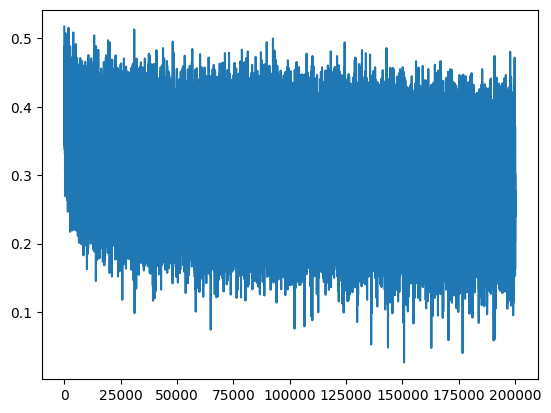

In [71]:
plt.plot(lossi) #lossi is a python list of floats

In [60]:
# Lets fix above
# Remember that...
torch.arange(10).view(5,-1) #the -1 allows pytorch to automatically work out what the correct dimentionality should be, based on # of elements (10) so (5, 2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [61]:
# 200 rows of 1000 elements = 200,000 total loss calcuations
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

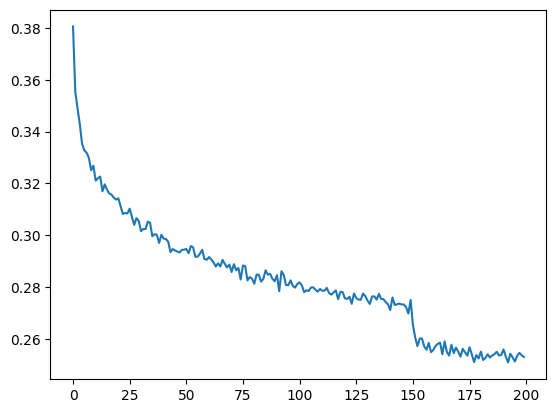

In [125]:
# By plotting the mean we get a much better picture of how the loss is changing over time
# The second dip is when we adjust the learning rate decay for the second time
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [126]:
# put layers in eval mode (needed for batchnorm)
for layer in model.layers:
    layer.training = False

In [127]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits ,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7676935195922852
val 1.9939253330230713


### performance log
* original (3 charachter context + 200 hidden neurons, 12k parameters): train 2.058, val 2.105
* context: 3 -> 8 (22k parameters): train 1.918, val 2.027
* flat -> hierarchical (22k params): train 1.941, val 2.029
* scaled up network: n_embed 24, n_hidden 128 (76k params): train 1.769, val 1.993

In [128]:
# Sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        #Forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


kimari.
clem.
jayden.
aceten.
amelyn.
lian.
harlie.
paelia.
aidence.
harli.
thuselle.
aysin.
rhettleigh.
zephyra.
ja.
ana.
jude.
berry.
miraylos.
markard.


### Next time:
Why convolutions? Brief preview/hint

In [129]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [130]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [131]:

# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [132]:
# convolution is a "for loop"
# the "for loop" takes place inside the CUDA Kernel and hidden away
# it enables the re-use of nodes by the sliding of input sequences
# allows us to forward Linear layers efficiently over space